## Imports

In [ ]:
import tensorflow as tf
import os # accessing file systems
import matplotlib.pyplot as plt

In [ ]:
import cv2
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class_list = os.listdir("/content/drive/MyDrive/datasets/data")
# print(class_list)
class_list = ['bengal_cat','bombay_cat','himalayan_cat','persian_cat']
print(class_list)

['bengal_cat', 'bombay_cat', 'himalayan_cat', 'persian_cat']


In [ ]:
# controlling the use of gpu memory
# gpus = tf.config.experimental.list_physical_devices("GPU")
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
# gpus

## Modifying data names for easy labeling

In [ ]:
# os.listdir(os.path.join("data", class_list[0]))

In [ ]:
# breed_path = "data\breed" = os.path.join("data", breed)
# list = os.listdir(breed_path) # lists name of all images
# print(list)
# image_exts = ['.jpeg','.jpg', '.bmp', '.png']
# for breed in class_list:
#     for cnt, filename in enumerate(os.listdir(os.path.join("/content/drive/MyDrive/datasets/data", breed))):
#         img_path = os.path.join(os.path.join("/content/drive/MyDrive/datasets/data", breed), filename) # path of current image
#         # print(img_path)
#         img_path_ext = os.path.splitext(img_path)[1] # we get the extension of image at the path
#         # print(img_path_ext)
#         if(img_path_ext in image_exts):
#             dst = f"{breed}{str(cnt)}{img_path_ext}"
#             src = f"{os.path.join('/content/drive/MyDrive/datasets/data', breed)}/{filename}"  # foldername/filename, if .py file is outside folder
#             dst = f"{os.path.join('/content/drive/MyDrive/datasets/data', breed)}/{dst}"
#             os.rename(src, dst)


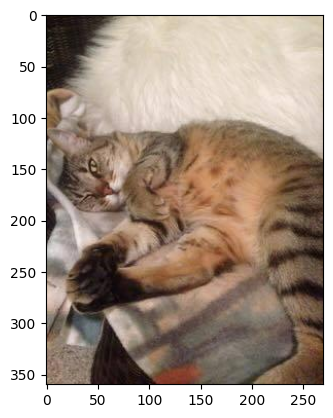

In [ ]:
sample_img = cv2.imread(os.path.join("/content/drive/MyDrive/datasets/data", "bengal_cat", "bengal_cat1098.jpg"))
plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)) # openCV reads as BGR and not RGB

## Loading the dataset

In [ ]:
# tf.keras.utils.image_dataset_from_directory??

In [ ]:
data = tf.keras.utils.image_dataset_from_directory("/content/drive/MyDrive/datasets/data",
                                                   batch_size=32,
                                                   # image_size=(512, 512),
                                                   class_names=class_list
                                                   )
# builds the dataset by labeling the images, resizing the images and even batching the images

Found 4558 files belonging to 4 classes.


In [ ]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
print(batch[0].shape, batch[1].shape)

(32, 256, 256, 3) (32,)


In [ ]:
batch[1]
# 0 - bengal
# 1 - bombay
# 2 - himalayan
# 3 - persian

array([1, 0, 0, 0, 3, 3, 0, 0, 0, 2, 2, 3, 1, 0, 2, 2, 2, 3, 3, 3, 3, 3,
       0, 3, 1, 1, 0, 1, 1, 2, 3, 2], dtype=int32)

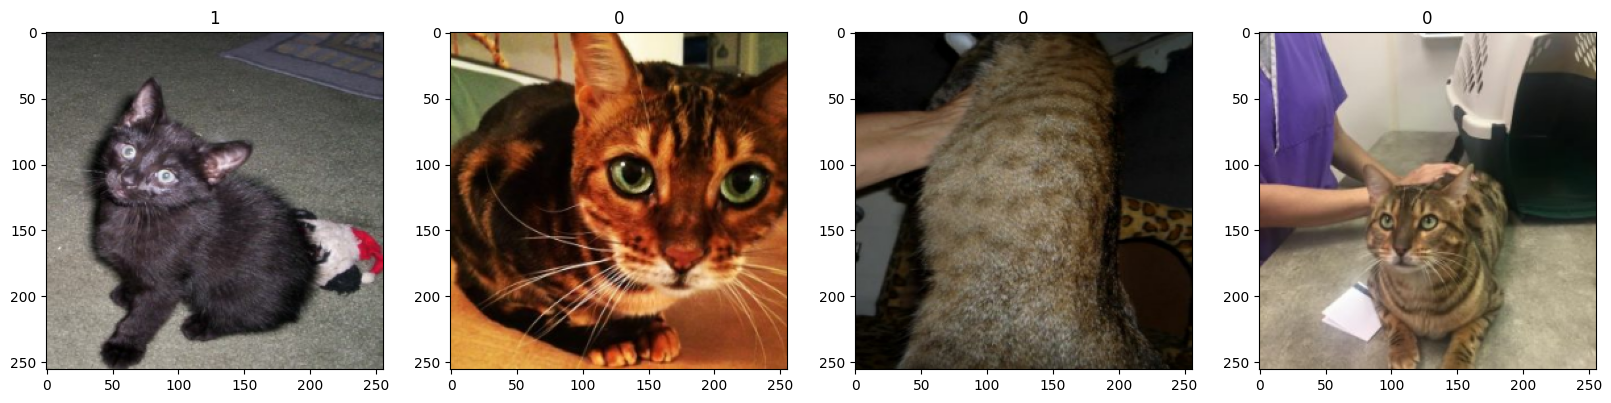

In [ ]:
# know the current batch
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]): # 1st 4 images of current batch
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

plt.show()

## Preprocess the data

In [ ]:
# scale the data
data = data.map(lambda x, y: (x/255.0, y)) # x=pixel values and y=label

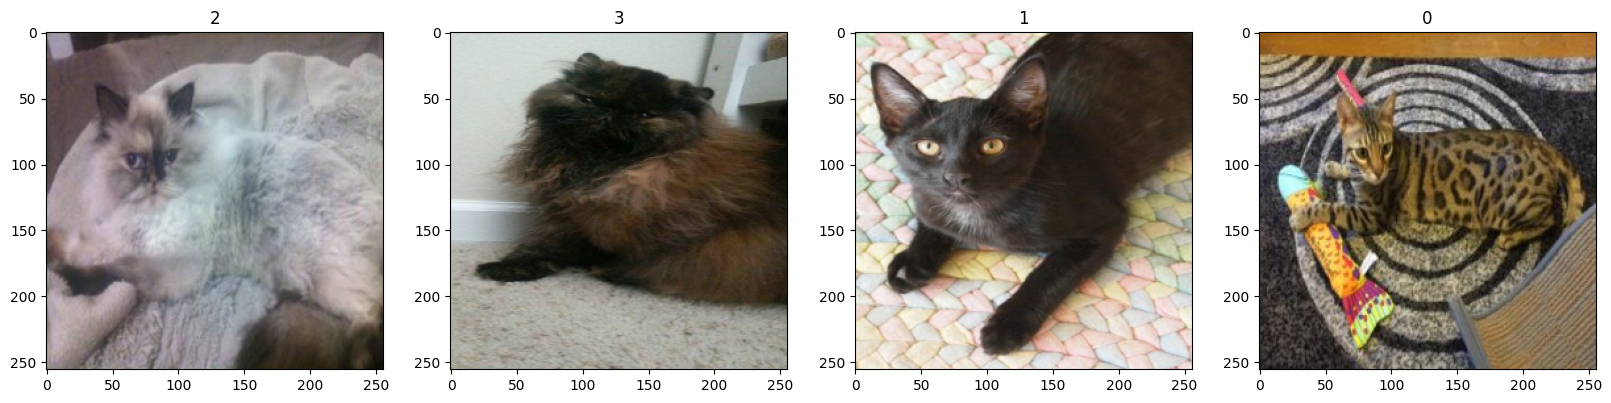

In [ ]:
new_batch = data.as_numpy_iterator().next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(new_batch[0][:4]): # 1st 4 images of current batch
    ax[idx].imshow(img)
    ax[idx].title.set_text(new_batch[1][idx])

plt.show()

# note that the pixel values values are now between 0. and 1.

## Train-Test-Validation Split

In [ ]:
len(data) # number of batches

143

In [ ]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)
test_size = int(len(data)*0.1)+1
print(train_size+val_size+test_size) # = 143 is a must

143


In [ ]:
# split the data
train = data.take(train_size) # tf method to take amount of data
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [ ]:
len(train), len(val), len(test) # number of batches

(100, 28, 15)

## Using a pretrained model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (256, 256, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# base_model.summary()

In [ ]:
# freeze the base model
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [ ]:
custom_model = Sequential()

custom_model.add(base_model)
custom_model.add(global_average_layer)
# custom_model.add(Flatten())
custom_model.add(Dense(512, activation="relu"))
custom_model.add(Dropout(0.5))
custom_model.add(Dense(4, activation="softmax"))

In [ ]:
custom_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 14,979,396
Trainable params: 264,708
Non-trainable params: 14,714,688
____________________________________

In [ ]:
custom_model.compile(
    optimizer='adam',
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
logdir = "logs"
# directory where all the model training stages (checkpoints) will be added

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
model_history = custom_model.fit(train, epochs=15, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/15
100/100 [==============================] - 39s 365ms/step - loss: 0.9899 - accuracy: 0.5753 - val_loss: 0.7183 - val_accuracy: 0.7388
Epoch 2/15
100/100 [==============================] - 32s 312ms/step - loss: 0.7139 - accuracy: 0.7172 - val_loss: 0.6156 - val_accuracy: 0.7801
Epoch 3/15
100/100 [==============================] - 38s 371ms/step - loss: 0.6137 - accuracy: 0.7456 - val_loss: 0.5585 - val_accuracy: 0.8058
Epoch 4/15
100/100 [==============================] - 38s 370ms/step - loss: 0.5825 - accuracy: 0.7619 - val_loss: 0.5520 - val_accuracy: 0.7913
Epoch 5/15
100/100 [==============================] - 32s 314ms/step - loss: 0.5468 - accuracy: 0.7834 - val_loss: 0.5634 - val_accuracy: 0.7857
Epoch 6/15
100/100 [==============================] - 38s 370ms/step - loss: 0.5109 - accuracy: 0.8000 - val_loss: 0.5037 - val_accuracy: 0.8170
Epoch 7/15
100/100 [==============================] - 32s 317ms/step - loss: 0.5094 - accuracy: 0.7950 - val_loss: 0.4991 - val_ac

In [ ]:
# training further might lead to overfitting on train data

In [63]:
custom_model.save(os.path.join('/content/drive/MyDrive/datasets/models','cat_breed_classifier_pretrained_vgg16_15_epoch.h5')) # saving the model

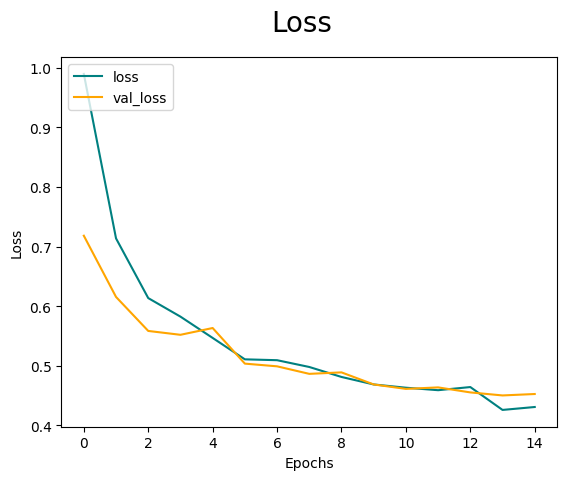

In [64]:
fig = plt.figure()
plt.plot(model_history.history['loss'], color='teal', label='loss')
plt.plot(model_history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

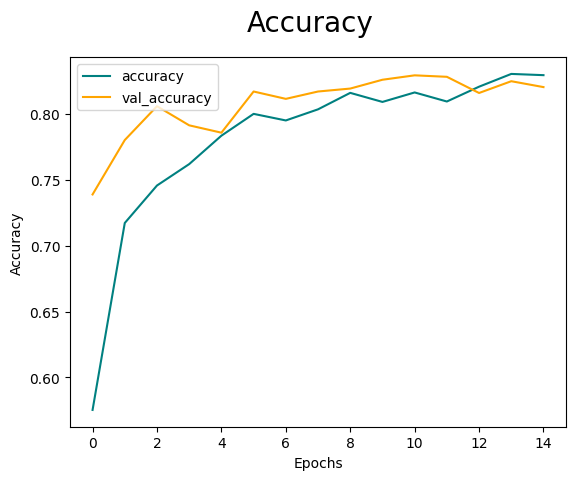

In [65]:
fig = plt.figure()
plt.plot(model_history.history['accuracy'], color='teal', label='accuracy')
plt.plot(model_history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")
plt.show()

## Model evaluation

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, Accuracy

In [ ]:
pre = Precision()
recall = Recall()
binacc = Accuracy()

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = custom_model.predict(X)
    # yhat = tf.nn.softmax(yhat, axis=1) # use when from_logit=True
    # print(yhat)
    yhat = tf.math.argmax(yhat, axis=1)
    pre.update_state(y, yhat)
    recall.update_state(y, yhat)
    binacc.update_state(y, yhat)

print(f"Precision is {pre.result()}, Recall is {recall.result()}, Accuracy is {binacc.result()}, F1Score is {(2*pre.result()*recall.result())/(pre.result()+recall.result())}")

1/1 [==============================] - 0s 149ms/step
Precision is 0.9905956387519836, Recall is 0.913294792175293, Accuracy is 0.7813853025436401, F1Score is 0.9503759741783142


## Testing on new image

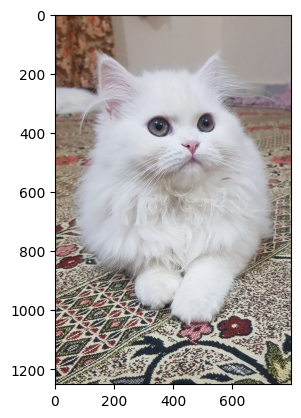

In [ ]:
test_img = cv2.imread("/content/HD-wallpaper-persian-cat-cat-kitten-little.jpg")
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.show()

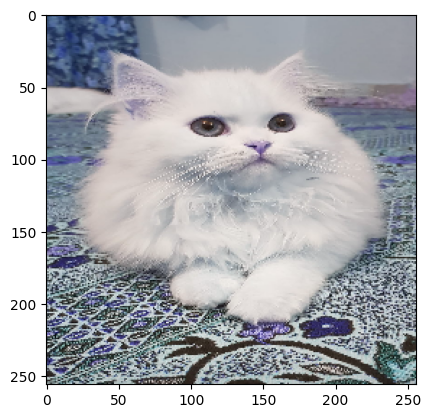

In [ ]:
resize_test = tf.image.resize(test_img, (256,256))
plt.imshow(resize_test.numpy().astype(int))
plt.show()

In [ ]:
resize_test.shape, np.expand_dims(resize_test/255.0, 0).shape

(TensorShape([256, 256, 3]), (1, 256, 256, 3))

In [ ]:
yhat = tf.math.argmax(custom_model.predict(np.expand_dims(resize_test/255.0, 0)), axis=1) # keras expects data as batches

1/1 [==============================] - 0s 21ms/step


In [ ]:
yhat

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>

In [ ]:
print("predicted breed is",class_list[yhat[0]])

predicted breed is persian_cat


## Load and try

In [ ]:
from tensorflow.keras.saving import load_model
neuu_mewdel = load_model("/content/drive/MyDrive/datasets/models/cat_breed_classifier_pre_vgg16_5_epoch.h5")

In [ ]:
yhat = tf.math.argmin(neuu_mewdel.predict(np.expand_dims(resize_test/255.0, 0)),axis=1)
yhat

1/1 [==============================] - 0s 19ms/step


<tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>

In [ ]:
match(yhat):
    case 0: print("predicted breed - bengal")
    case 1: print("predicted breed - bombay")
    case 2: print("predicted breed - himalayan")
    case 3: print("predicted breed - persian")
    case _: print("none of known breeds !")

predicted breed - persian


## Training the CNN model

In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization

In [ ]:
# logdir = "logs"
# directory where all the model training stages (checkpoints) will be added

In [ ]:
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
# hist = model1.fit(train, epochs=6, validation_data=val, callbacks=[tensorboard_callback])

In [ ]:
# fig = plt.figure()
# plt.plot(hist.history['loss'], color='teal', label='loss')
# plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
# fig.suptitle('Loss', fontsize=20)
# plt.legend(loc="upper left")
# plt.show()

In [ ]:
# fig = plt.figure()
# plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
# plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
# fig.suptitle('Accuracy', fontsize=20)
# plt.legend(loc="upper left")
# plt.show()

###ZF Net

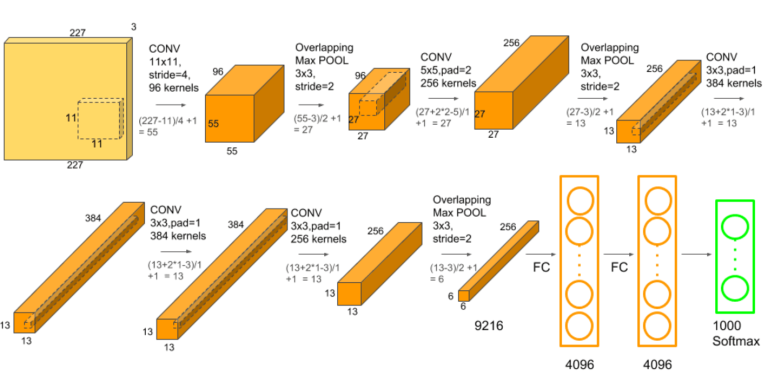

In [ ]:
# zf_net = tf.keras.Sequential()

# zf_net.add(tf.keras.layers.Conv2D(filters=48, kernel_size=(11,11), strides=(4,4), input_shape=(256,256,3)))
# zf_net.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=2))

# zf_net.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(5,5), padding="same"))
# zf_net.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=2))

# zf_net.add(tf.keras.layers.Conv2D(filters=192, kernel_size=(3,3), padding="same"))

# zf_net.add(tf.keras.layers.Conv2D(filters=192, kernel_size=(3,3), padding="same"))

# zf_net.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same"))
# zf_net.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=2))

# zf_net.add(tf.keras.layers.Flatten())

# zf_net.add(Dense(2048, activation="relu"))
# zf_net.add(Dropout(0.5))
# zf_net.add(Dense(2048, activation="relu"))
# zf_net.add(Dropout(0.5))
# zf_net.add(Dense(4, activation="softmax"))

In [ ]:
# zf_net.summary()

In [ ]:
# from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
# pre = Precision()
# recall = Recall()
# binacc = BinaryAccuracy()

# for batch in test.as_numpy_iterator():
#     X, y = batch
#     yhat = zf_net.predict(X)
#     # yhat = tf.nn.softmax(yhat, axis=1)
#     # print(yhat)
#     yhat = tf.math.argmax(yhat, axis=1)
#     pre.update_state(y, yhat)
#     recall.update_state(y, yhat)
#     binacc.update_state(y, yhat)

# print(f"Precision is {pre.result()}, Recall is {recall.result()}, Accuracy is {binacc.result()}, F1Score is {(2*pre.result()*recall.result())/(pre.result()+recall.result())}")
# # epoch 13
# # Precision is 0.9451754093170166, Recall is 0.8886597752571106, Accuracy is 0.4002869427204132, F1Score is 0.9160467386245728
# # epoch 15
# # Precision is 0.9372385144233704, Recall is 0.9372385144233704, Accuracy is 0.4002869427204132, F1Score is 0.9372385740280151
# # epoch 17
# # Precision is 0.964205801486969, Recall is 0.8654618263244629, Accuracy is 0.384505033493042, F1Score is 0.912169337272644
# # epoch 20
# # Precision is 0.963718831539154, Recall is 0.8835758566856384, Accuracy is 0.4045911133289337, F1Score is 0.9219088554382324
# # epoch 22
# # Precision is 0.9504132270812988, Recall is 0.9330628514289856, Accuracy is 0.4002869427204132, F1Score is 0.9416581392288208

In [ ]:
# zf_net.save(os.path.join('/content/drive/MyDrive/datasets/models','cat_breed_classifier_zf_net_20_epochs.h5'))